# Training a picasso predictor

This notebook shows how one can train a `picasso` model to make predictions of gas thermodynamics from halo properties.
For a full documentation of the predictor objects and their methods, see {doc}`../api/predictors`.

In [1]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from tqdm.notebook import trange

from picasso import predictors
from picasso.test_data import halos, profs

import seaborn as sns
sns.set_style("darkgrid")
sns.set_theme("notebook")

benchmark = True

## Differentiating predictions

Since the model prediction functions described above are entirely implemented in JAX, they are fully differentiable.
Let's start by defining an untrained predictor, such that the prediction functions take as input a dict of neural network parameters $\vartheta_{\rm net}$.
We'll mimic the "minimal" model of Kéruzoré et al. (2024), i.e. a model that takes as inputs halo mass and concentration.
This means the input layer will have 2 features, and the output layer will have 8 (corresponding to the 8 parameters of the gas model).
For demonstration purposes, we use an MLP with one hidden layer with 8 features.

In [2]:
model = predictors.PicassoPredictor(
    predictors.FlaxRegMLP(2, 8, [8,], ["selu", "selu", "sigmoid"]),
    predictors.minimal_576._transform_x,  # The input scalings for the minimal_576 model
    predictors.minimal_576._transform_y,  # The output scalings for the minimal_576 model
    input_names=predictors.minimal_576.input_names
)

`flax` allows us to initialize $\vartheta_{\rm net}$ easily:

In [3]:
theta_nn = model.mlp.init(jax.random.PRNGKey(44), jnp.ones(model.mlp.X_DIM))
print(f"{theta_nn=}")

theta_nn={'params': {'input': {'kernel': Array([[ 0.03842447, -0.06375846],
       [ 1.4234861 , -0.33939242]], dtype=float32), 'bias': Array([0., 0.], dtype=float32)}, 'dense1': {'kernel': Array([[-0.042185  , -0.7779425 ,  1.1562326 , -0.2546578 , -0.5690918 ,
         0.56547344,  0.03781918, -0.47313142],
       [ 1.0343004 ,  0.09225573,  0.04856016, -0.36422998, -0.2005813 ,
        -1.1775992 ,  0.5434312 ,  1.2453555 ]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'output': {'kernel': Array([[ 7.8989536e-02,  7.0438385e-01,  1.0798373e-01, -3.7004817e-01,
        -7.8189468e-01,  3.6114028e-01,  7.4631339e-01,  8.4025212e-02],
       [-2.6573351e-04,  3.7197936e-01, -6.9597310e-01, -1.7070572e-01,
        -6.5567094e-01,  1.4083256e-01, -6.4938289e-01, -5.2993375e-01],
       [-6.3911790e-01,  8.5570492e-02, -2.9292062e-01, -7.5498748e-01,
         8.8445395e-02,  8.0396719e-02,  1.2768888e-01,  2.5018033e-01],
       [-1.9778068e-01,  5.100

Now, we can write a loss function.
For example, let's write a mean square error function that compares the predictions of the gas thermodynamics with the halo properties found in the hydrodynamic simulations.
For illustration purposes, we use a very small set of 7 halos for which we have all inputs and true thermodynamic profiles:

In [4]:
phi = profs["phi"]
r_R500c = profs["r_R500"]

logM200c = halos["log M200"]
c200c = jnp.array(halos["c200"])
theta_halo = jnp.array([logM200c, c200c]).T

target = jnp.array(
    [
        profs["rho_g"],
        profs["P_tot"],
        profs["P_tot"] * (1 - profs["f_nt"]),
        profs["f_nt"]
    ]
)

def loss_fn_predict_parameters(theta_nn):
    preds = jnp.array(model.predict_gas_model(theta_halo, phi, r_R500c, r_R500c / 2, theta_nn))
    loss = jnp.mean((preds - target) ** 2)
    return loss


We can use `jax.value_and_grad` to compute, for an input $\vartheta_{\rm net}$, the value of the loss function and its gradients with respect to the components of $\vartheta_{\rm net}$:

In [5]:
loss_fn_and_grads = jax.jit(jax.value_and_grad(loss_fn_predict_parameters))
loss, grads = loss_fn_and_grads(theta_nn)
print(f"{loss=}")
print(f"{grads=}")

loss=Array(38074.707, dtype=float32)
grads={'params': {'dense1': {'bias': Array([ 58270.965 ,   1270.4316, -92806.1   , -12145.347 , -43320.977 ,
        56307.63  , 173724.16  , -70639.39  ], dtype=float32), 'kernel': Array([[ 1.83923594e+04, -1.64535843e+02, -3.24861094e+04,
        -5.07010547e+03, -1.41784795e+04,  1.87266016e+04,
         5.65332109e+04, -2.24610293e+04],
       [-7.80777002e+03,  1.21642752e+01,  1.31665459e+04,
         1.83023914e+03,  5.90263867e+03, -7.65198291e+03,
        -2.35170137e+04,  9.31161133e+03]], dtype=float32)}, 'input': {'bias': Array([-11739.606,  14578.093], dtype=float32), 'kernel': Array([[ -247.70917,  6898.421  ],
       [-3853.505  ,  2785.0266 ]], dtype=float32)}, 'output': {'bias': Array([ 1.4956983e+05,  5.1873672e+03,  2.2795432e+04, -1.9880947e+04,
       -1.7064436e+04, -2.9367275e+01, -1.7362104e-01,  4.6830207e-01],      dtype=float32), 'kernel': Array([[-3.8038750e+04, -1.3669747e+03, -5.9998457e+03,  4.3725933e+03,
         4.3

This loss function can then be optimized using, *e.g.*, `optax` (See the `optax` docs [here](https://optax.readthedocs.io/en/latest/index.html), in particular the tutorial to optimize the parameters of a `flax` model [here](https://optax.readthedocs.io/en/latest/_collections/examples/flax_example.html)):


In [6]:
optimizer = optax.adam(1e-2)
opt_state = optimizer.init(theta_nn)

@jax.jit
def train_step(theta_nn, opt_state):
    lt, grads = loss_fn_and_grads(theta_nn)

    updates, opt_state = optimizer.update(grads, opt_state, theta_nn)
    theta_nn = optax.apply_updates(theta_nn, updates)
    
    return theta_nn, opt_state, lt

all_lt, all_lv = [], []
for i in trange(100):
    theta_nn, opt_state, lt = train_step(theta_nn, opt_state)
    all_lt.append(lt)
all_lt = jnp.array(all_lt)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Training loss')

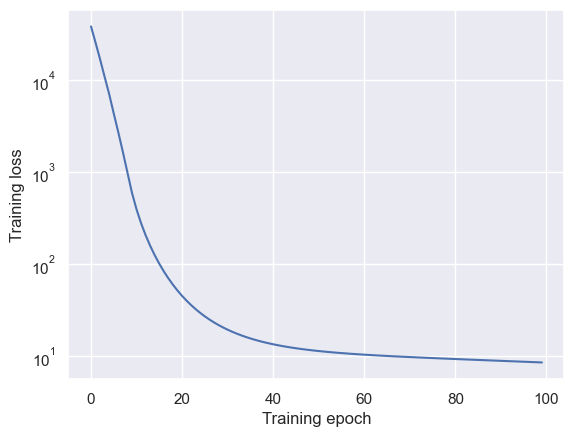

In [7]:
fig, ax = plt.subplots()
ax.plot(all_lt)
ax.set_yscale("log")
ax.set_xlabel("Training epoch")
ax.set_ylabel("Training loss")